In [1]:
#--------------------------- Importar librerias -------------------------------#

import pandas as pd # Cargar datos CSV
import numpy as np # Arrays
from sklearn.model_selection import train_test_split # División datos
import torch # PyTorch - Redes neuronales
import torch.nn as nn # Definir y entrenar redes neuronales
from torch import optim # Algoritmos de optimización
import torch.nn.functional as F # Funciones de activación
from torch.optim.lr_scheduler import StepLR # tasa de aprendizaje
import seaborn as sns # Matriz de confusión
import matplotlib.pyplot as plt # Gráficas
# Métricas de evaluación
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

#-------------------- Cargar los datos desde archivos CSV ---------------------#

# Cargar los datos de entrenamiento
X_train = pd.read_csv('/content/EstrogenReceptorStatus_Train.csv',index_col=0)
# Cargar las etiquetas de los datos de entrenamiento
y_train = pd.read_csv('/content/EstrogenReceptorStatus_Train_labels.txt',header=None)

# Cargar los datos de evaluación
X_test = pd.read_csv('/content/EstrogenReceptorStatus_Test.csv',index_col=0)
# Cargar las etiquetas de los datos de evaluación
y_test = pd.read_csv('/content/EstrogenReceptorStatus_Test_labels.txt',header=None)


In [2]:
#------------------- Convertir los datos a arreglos de numpy ------------------#

# X_train = X_train.to_numpy
X_train = np.asarray(X_train)
# y_train = y_train.to_numpy
y_train = np.asarray(y_train)

# X_test = X_test.to_numpy
X_test = np.asarray(X_test)
# y_test = y_test.to_numpy
y_test = np.asarray(y_test)

#------------------- Mapear los datos a tensores de PyTorch -------------------#

# Convertir los datos de entrenamiento y prueba en tensores
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))

# Aplanar los tensores - tensores unidimensionales
y_train = torch.flatten(y_train)
y_test = torch.flatten(y_test)

#---------------- Cambiar el tipo de datos de los tensores --------------------#

X_train = X_train.float() # Train - Punto flotante
y_train = y_train.long() # Train labels - entero largo
X_test = X_test.float() # Test - Punto flotante
y_test = y_test.long() # Test labels - entero largo

#-------------------- División de datos 60%, 20%, 20%  ------------------------#

# Dividir los datos en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#---------------------- Cambiar dimensión de etiquetas ------------------------#

# Agregar una dimensión adicional
y_train = y_train.unsqueeze(1)
y_val = y_val.unsqueeze(1)
y_test = y_test.unsqueeze(1)

# Cambiar el tipo de dato a float
y_train = y_train.float()
y_val = y_val.float()
y_test = y_test.float()

In [3]:
#--------------- Definición de la red neuronal feedforward --------------------#

# Se define una red neuronal feedforward con tres capas ocultas y una capa de
# salida con una sola neurona y función de activación Softmax para clasificación binaria

class FFNN(nn.Module):

    #  Inicialización del Modelo #
    def __init__(self):
        super().__init__() # Constructor
        torch.manual_seed(0) # Reproducibilidad

        # Definición de la arquitectura del modelo como una secuencia de capas #
        self.net = nn.Sequential(
            nn.Linear(162, 30), # Primera capa lineal - 162 entradas (características) y 30 salidas
            nn.ReLU(), # Función de activación ReLU - valores negativos a cero y valores positivos sin cambios
            nn.Linear(30, 30), # Segunda capa, transformación lineal - 30 entradas y 30 salidas
            nn.ReLU(), # Función de activación ReLU - valores negativos a cero y valores positivos sin cambios
            nn.Linear(30, 1), # Capa de salida - 30 entradas y 1 salida para clasificación binaria
            nn.Sigmoid() # Función de activación Sigmoide - rango entre 0-1
        )

    # Método Forward - define el paso hacia adelante de la red
    # Pasa el tensor dado X a través de las capas definidas anteriormente en self.net
    def forward(self, X):
        return self.net(X)

    # Método de Predicción
    # Dado un tensor de entrada X, calcula las predicciones de la red neuronal y las devuelve
    def predict(self, X):
        Y_pred = self.forward(X)
        return Y_pred

In [4]:
#----- Definición del Bucle de Entrenamiento con Validación y Early Stop ------#

'''
Se crea una función llamada fit_val_earlystop que toma como entrada:

- X_train (los datos de entrenamiento)
- y_train (las etiquetas del entrenamiento)
- X_val (los datos de validación)
- y_train (las etiquetas de validación)
- model (la arquitectura del modelo)
- opt (el optimizador)
- loss_fn (la función de pérdida)
- epochs (el número de épocas de entrenamiento)
- patience (el número de epocas que de no haber mejora, se detiene el entrenamiento)

Después de completar todas las épocas, la función devuelve una lista con las pérdidas
obtenidas en cada época en el entrenamiento y otra lista para similar para la validación.

En caso de cumplirse la condición de Early stoping, se detendrá el entrenamiento y se
regresaran las listas con las pérdidas obtenidas en entrenamiento y validación.
Además se imprimirá a pantalla la época en que se detuvo el entrenamiento y el número
de épocas consecutivas en que la pérdida no mejoró.
'''

# Establecer la semilla para funciones aleatorias de PyTorch
torch.manual_seed(42)

def fit_val_earlystop(X_train, y_train, X_val, y_val, model, opt, loss_fn, epochs, patience):

    # Listas para almacenar las pérdidas en cada época
    train_losses = []
    val_losses = []

    # Inicializar variables para Early Stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Iteración sobre el número de épocas
    for epoch in range(epochs):

        # Entrenamiento
        model.train()
        train_loss = loss_fn(model(X_train), y_train)  # Calculo de la Pérdida
        train_loss.backward()  # Backpropagation
        opt.step()  # Optimización
        opt.zero_grad()  # Reiniciar los gradientes de las variables a 0 (evitar acumulación de gradientes)
        train_losses.append(train_loss.item())  # Almacena la pérdida de entrenamiento actual

        # Validación
        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model(X_val), y_val)  # Calculo de la Pérdida en conjunto de validación
        val_losses.append(val_loss.item())  # Almacena la pérdida de validación actual

        # Implementar Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch + 1}')
                print(f'No se ha observado mejora en {patience} épocas consecutivas.')
                break

    return train_losses, val_losses


In [5]:
#--------------------- Establecimiento del Dispositivo ------------------------#

# Establecimiento de CPU como dispositivo
device = torch.device("cpu")

# Transferencia de Datos y Modelo al Dispositivo CPU
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

# Creación del Modelo y Transferencia al Dispositivo CPU
fn = FFNN()
fn.to(device)

FFNN(
  (net): Sequential(
    (0): Linear(in_features=162, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [6]:
#------------ Definición de hiperparámetros para el entrenamiento -------------#

# Función de pérdida utilizando la entropía cruzada, usada para problemas de clasificación
loss_fn = nn.BCELoss()

# Optimizador - algoritmo de descenso de gradiente estocástico (SGD)
# Tasa de aprendizaje de 0.01
opt = optim.SGD(fn.parameters(), lr=0.0085)

# Se establece el número de épocas para el entrenamiento
epocas = 10000

# Se establece la paciencia (numero de épocas donde la pérdida no mejora)
paciencia = 40


In [7]:
#------------ Entrenamiento del modelo con validación y Early Stop ------------#

# Se realiza el entrenamiento aplicando la función fit_val_earlystop
# Se guardan las pérdidas obtenidas durante el entrenamiento y la validación
t2_train_losses, t2_val_losses = fit_val_earlystop(X_train, y_train, X_val, y_val, fn, opt, loss_fn, epocas, paciencia)

# Se imprime a pantalla la pérdida final del entrenamiento y la validación
print('Final training loss', t2_train_losses[-1])
print('Final validation loss', t2_val_losses[-1])

Early stopping at epoch 1323
No se ha observado mejora en 40 épocas consecutivas.
Final training loss 0.3231065273284912
Final validation loss 0.40331706404685974


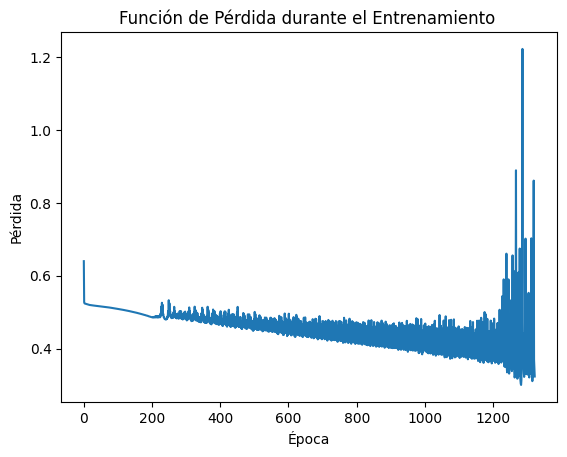

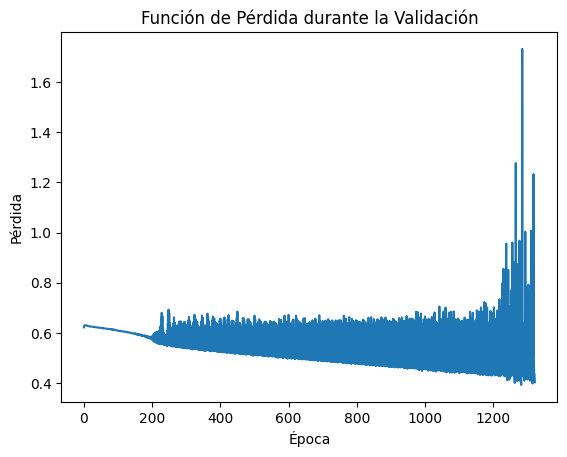

In [8]:
#----------------------------- Función de Pérdida ------------------------------#

# Entrenamiento
plt.plot(t2_train_losses)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Función de Pérdida durante el Entrenamiento ')
plt.show()
# Validación
plt.plot(t2_val_losses)
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Función de Pérdida durante la Validación')
plt.show()

In [9]:
# --------------- Épocas con menor y mayor valor de pérdida -------------------#

# Entrenamiento
print(f'El valor mínimo de pérdida durante el entrenamiento fue {min(t2_train_losses)} en la época {t2_train_losses.index(min(t2_train_losses))}')
print(f'El valor máximo de pérdida durante el entrenamiento fue {max(t2_train_losses)} en la época {t2_train_losses.index(max(t2_train_losses))}')

# Validación
print(f'El valor mínimo de pérdida durante la validación fue {min(t2_val_losses)} en la época {t2_val_losses.index(min(t2_val_losses))}')
print(f'El valor máximo de pérdida durante la validación fue {max(t2_val_losses)} en la época {t2_val_losses.index(max(t2_val_losses))}')

El valor mínimo de pérdida durante el entrenamiento fue 0.3000054359436035 en la época 1282
El valor máximo de pérdida durante el entrenamiento fue 1.2226577997207642 en la época 1286
El valor mínimo de pérdida durante la validación fue 0.3928053677082062 en la época 1282
El valor máximo de pérdida durante la validación fue 1.7320414781570435 en la época 1285


In [10]:
#--------------------- Función para métricas de evaluación --------------------#

def plot_confusion_matrix(y_true, y_pred_classes):

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, X, y_true):

    # Obtener las predicciones del modelo
    y_pred = model.predict(X)

    # Calcular la precisión
    y_pred_classes = torch.round(torch.sigmoid(y_pred)).detach().cpu().numpy()
    accuracy = accuracy_score(y_true, y_pred_classes)
    print("Accuracy: {:.4f}".format(accuracy))

    # Visualizar la matriz de confusión como una imagen con seaborn
    plot_confusion_matrix(y_true, y_pred_classes)

    # Calcular y mostrar la curva ROC y el área bajo la curva (AUC)
    y_scores = torch.sigmoid(y_pred).detach().cpu().numpy()[:, 0]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    print("AUC: {:.4f}".format(auc))

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


Evaluation on Training Set:
Accuracy: 0.7829


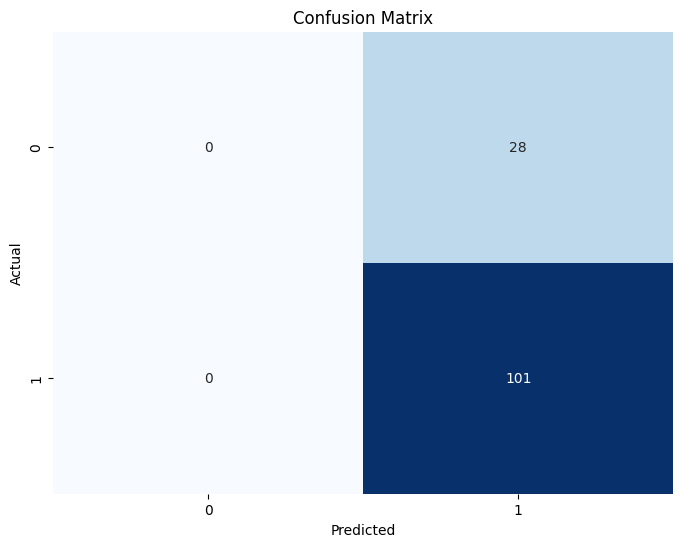

AUC: 0.9565


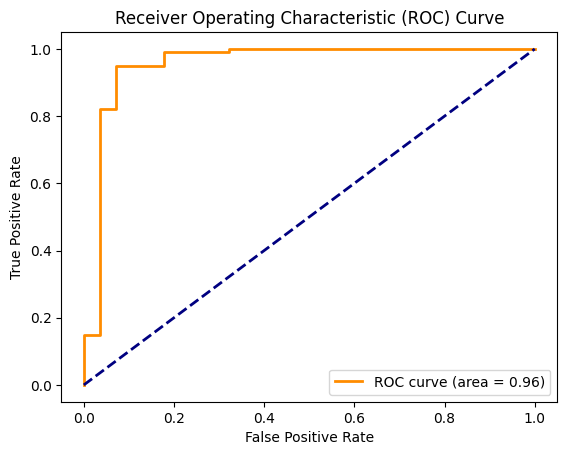

In [11]:
#------------------ Evaluar en el conjunto de entrenamiento -------------------#

print("Evaluation on Training Set:")
evaluate_model(fn, X_train, y_train)


Evaluation on Test Set:
Accuracy: 0.6818


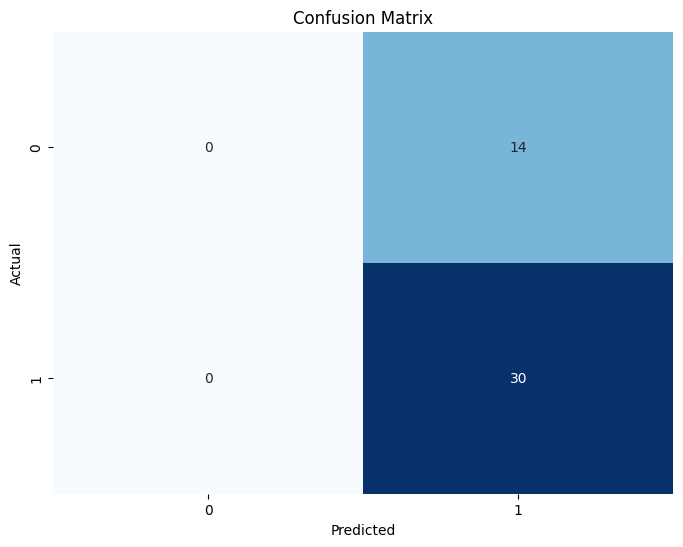

AUC: 0.8524


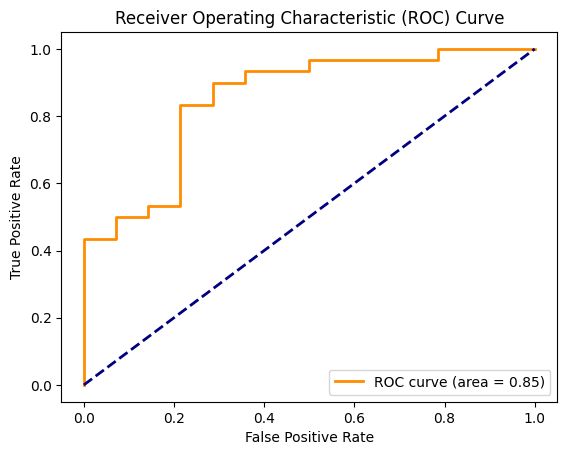

In [12]:
#---------------------- Evaluar en el conjunto de prueba ----------------------#

print("\nEvaluation on Test Set:")
evaluate_model(fn, X_test, y_test)